# CNN-VAE 

## 1. Imports and Setup

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import glob
import imageio # For creating GIFs/videos


torch.manual_seed(42)
np.random.seed(42)


try:
    if os.path.exists('/content/drive/MyDrive/'): # Check for Colab's Drive mount
        PROJECT_BASE_PATH = '/content/drive/MyDrive/SeminartalkVAEsNFs/' #<-- ADJUST IF NEEDED
        print(f"Project base path set to Google Drive: {PROJECT_BASE_PATH}")
    else:
        PROJECT_BASE_PATH = './SeminartalkVAEsNFs/' # Fallback for local execution
        print(f"Google Drive not found or not mounted at standard Colab path. Project base path set to local: {PROJECT_BASE_PATH}")
except NameError: # If 'drive' object doesn't exist (e.g. not in Colab)
    PROJECT_BASE_PATH = './SeminartalkVAEsNFs/'
    print(f"Project base path set to local: {PROJECT_BASE_PATH}")

if not os.path.exists(PROJECT_BASE_PATH):
    os.makedirs(PROJECT_BASE_PATH)
    print(f"Created project base directory: {PROJECT_BASE_PATH}")

# Define specific directories within the project base path
MODELS_DIR = os.path.join(PROJECT_BASE_PATH, 'VAE_models')
RESULTS_DIR = os.path.join(PROJECT_BASE_PATH, 'results_cnn_vae_fruit') # General results
TRAIN_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'train2')
TEST_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'test2')
DUMMY_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'dummy_images')


# Create these directories if they don't exist
for dir_path in [MODELS_DIR, RESULTS_DIR, TRAIN_IMG_DIR, TEST_IMG_DIR, DUMMY_IMG_DIR]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")

# Create a few dummy images if the dummy directory is empty (for testing notebook flow)
if not os.listdir(DUMMY_IMG_DIR): # Check if directory is empty
    print(f"Populating {DUMMY_IMG_DIR} with dummy images...")
    for i in range(5):
        try:
            # Create images with dimensions somewhat similar to expected inputs before resize
            dummy_pil_img = Image.fromarray(np.random.randint(0, 256, (200, 200, 3), dtype=np.uint8))
            dummy_pil_img.save(os.path.join(DUMMY_IMG_DIR, f'dummy_img_{i}.png'))
        except Exception as e:
            print(f"Error creating dummy image: {e}")


Project base path set to Google Drive: /content/drive/MyDrive/SeminartalkVAEsNFs/


## 2. Hyperparameters and Device Configuration (Same as before or adjust as needed)

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 32 #16
EPOCHS = 100
LEARNING_RATE = 5e-5
LATENT_DIM = 128 # 256
IMG_CHANNELS = 3
IMG_HEIGHT = 96 # original 256 # 205
IMG_WIDTH = 96 # original 320 # 256
SAVE_MODEL = EPOCHS//3

BETA_KLD = 0.5

Using device: cuda


## 3. Data Loading 
Make sure `TRAIN_IMG_DIR` and `TEST_IMG_DIR` are correctly defined within this section or globally if you prefer.

Found 1418 images in /content/drive/MyDrive/SeminartalkVAEsNFs/train2
Found 30 images in /content/drive/MyDrive/SeminartalkVAEsNFs/test2
Train loader size: 1418, Test loader size: 30

Example training images (resized to 96x96):


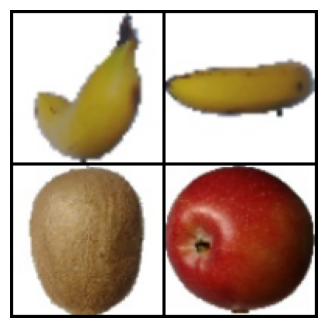

In [5]:
# Data Loading (CustomImageDataset class and DataLoader setup - same as previous example)
# Ensure TRAIN_IMG_DIR and TEST_IMG_DIR are correctly defined here.

TRAIN_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'train2')
TEST_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'test2')

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, limit=None): # Added limit for quicker testing
        self.img_dir = img_dir
        all_img_paths = glob.glob(os.path.join(img_dir, '*.jpg')) + \
                        glob.glob(os.path.join(img_dir, '*.png')) + \
                        glob.glob(os.path.join(img_dir, '*.jpeg'))
        if limit and len(all_img_paths) > limit:
            self.img_paths = np.random.choice(all_img_paths, limit, replace=False).tolist()
            print(f"Limited dataset to {limit} images from {img_dir}")
        else:
            self.img_paths = all_img_paths
        self.transform = transform
        if not self.img_paths:
            print(f"WARNING: No images found in {img_dir}. Check extensions or path.")
        else:
            print(f"Found {len(self.img_paths)} images in {img_dir}")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, 0 # Return 0 as a dummy label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}. Skipping.")
            # Return a dummy image or handle appropriately
            return torch.zeros(IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH), 0

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])


DUMMY_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'dummy_images') # Create this folder if it doesn't exist
if not os.path.exists(DUMMY_IMG_DIR):
    os.makedirs(DUMMY_IMG_DIR)
    # Create a few dummy images if the directory is new
    for i in range(5):
        try:
            dummy_pil_img = Image.fromarray(np.random.randint(0, 256, (280, 350, 3), dtype=np.uint8))
            dummy_pil_img.save(os.path.join(DUMMY_IMG_DIR, f'dummy_img_{i}.png'))
        except Exception as e:
            print(f"Error creating dummy image: {e}")

YOUR_TRAIN_IMG_DIR = TRAIN_IMG_DIR # Use TRAIN_IMG_DIR or DUMMY_IMG_DIR for testing
YOUR_TEST_IMG_DIR = TEST_IMG_DIR   # Use TEST_IMG_DIR or DUMMY_IMG_DIR for testing
# YOUR_TRAIN_IMG_DIR = DUMMY_IMG_DIR # Uncomment to use dummy images for quick tests
# YOUR_TEST_IMG_DIR = DUMMY_IMG_DIR  # Uncomment to use dummy images for quick tests

# Using a small limit for quick testing of the notebook structure
DATASET_LIMIT = None # Set to None to use all images

try:
    train_dataset = CustomImageDataset(img_dir=YOUR_TRAIN_IMG_DIR, transform=transform, limit=DATASET_LIMIT)
    test_dataset = CustomImageDataset(img_dir=YOUR_TEST_IMG_DIR, transform=transform, limit=DATASET_LIMIT // 2 if DATASET_LIMIT else None)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True if DEVICE.type == 'cuda' else False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True if DEVICE.type == 'cuda' else False)
    print(f"Train loader size: {len(train_loader.dataset)}, Test loader size: {len(test_loader.dataset)}")
except Exception as e:
    print(f"Error initializing dataset/dataloader: {e}. Using dummy data.")
    class DummyDataset(Dataset):
        def __init__(self, size, length): self.length = length; self.data = torch.randn(length, *size)
        def __getitem__(self, index): return self.data[index], 0
        def __len__(self): return self.length
    train_loader = DataLoader(DummyDataset((IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE*2), batch_size=BATCH_SIZE)
    test_loader = DataLoader(DummyDataset((IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE*2), batch_size=BATCH_SIZE)

def show_tensor_images(image_tensor, num_images=4, nrow=2, show=True, save_path=None, title=None):
    # Determine size from tensor if not provided, assuming B, C, H, W
    # This function doesn't use the global IMG_HEIGHT, IMG_WIDTH directly for grid creation
    # but relies on the input tensor's shape.
    image_tensor = (image_tensor + 1) / 2 if image_tensor.min() < 0 else image_tensor
    image_unflat = image_tensor.detach().cpu().clamp(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.figure(figsize=(nrow*2, (num_images//nrow)*2 if num_images > nrow else 4)) # Adjust figure size
    if title:
        plt.title(title)
    if show:
        plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        plt.axis('off')
        plt.show()
    if save_path:
        save_image(image_grid, save_path)
        print(f"Saved image to {save_path}")

if len(train_loader.dataset) > 0 and isinstance(train_loader.dataset, CustomImageDataset):
     try:
        example_images, _ = next(iter(train_loader))
        if example_images.numel() > 0: # Check if tensor is not empty
             print(f"\nExample training images (resized to {IMG_HEIGHT}x{IMG_WIDTH}):")
             show_tensor_images(example_images, num_images=min(BATCH_SIZE, 4), nrow=2)
     except StopIteration:
        print("Train loader is empty, cannot show example images.")

## 4. CNN-VAE Model Definition 

In [6]:
class CNNVAE_Custom(nn.Module):
    def __init__(self, img_channels, latent_dim, img_height, img_width):
        super(CNNVAE_Custom, self).__init__()
        self.latent_dim = latent_dim
        self.img_height = img_height
        self.img_width = img_width

        # === Encoder ===
        # --- 6. OPTION TO INCREASE MODEL CAPACITY (CHANNELS) ---
        # Original channels: 32, 64, 128, 256, 512
        # Example increased capacity: 64, 128, 256, 512, 512 (or even more)
        enc_c1, enc_c2, enc_c3, enc_c4, enc_c5 = 32, 64, 128, 256, 512
        #enc_c1, enc_c2, enc_c3, enc_c4, enc_c5 = 64, 128, 256, 512, 512 # Example: Increased capacity

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(img_channels, enc_c1, kernel_size=4, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(enc_c1),
            nn.Conv2d(enc_c1, enc_c2, kernel_size=4, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(enc_c2),
            nn.Conv2d(enc_c2, enc_c3, kernel_size=4, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(enc_c3),
            nn.Conv2d(enc_c3, enc_c4, kernel_size=4, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(enc_c4),
            nn.Conv2d(enc_c4, enc_c5, kernel_size=4, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(enc_c5),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, img_channels, img_height, img_width)
            conv_output_shape = self._get_conv_output_shape(dummy_input)
            self.flattened_size = conv_output_shape[1] * conv_output_shape[2] * conv_output_shape[3]
            self.unflatten_channels = conv_output_shape[1] # This will be enc_c5
            self.unflatten_height = conv_output_shape[2]
            self.unflatten_width = conv_output_shape[3]
            # print(f"CNNVAE_Custom Init: Encoder CNN output shape (before flatten): B_dummy{conv_output_shape}")
            # print(f"CNNVAE_Custom Init: Flattened size: {self.flattened_size}")
            # print(f"CNNVAE_Custom Init: Unflatten shape: C={self.unflatten_channels}, H={self.unflatten_height}, W={self.unflatten_width}")

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_log_var = nn.Linear(self.flattened_size, latent_dim)

        # === Decoder ===
        self.decoder_fc = nn.Linear(latent_dim, self.flattened_size)

        # Decoder channels should mirror encoder's chosen capacity
        # The self.unflatten_channels is already enc_c5 (e.g. 512)
        dec_c1, dec_c2, dec_c3, dec_c4 = enc_c4, enc_c3, enc_c2, enc_c1 # e.g., 256, 128, 64, 32

        # --- 7. USE LeakyReLU IN DECODER ---
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(self.unflatten_channels, dec_c1, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True), nn.BatchNorm2d(dec_c1),
            nn.ConvTranspose2d(dec_c1, dec_c2, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True), nn.BatchNorm2d(dec_c2),
            nn.ConvTranspose2d(dec_c2, dec_c3, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True), nn.BatchNorm2d(dec_c3),
            nn.ConvTranspose2d(dec_c3, dec_c4, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True), nn.BatchNorm2d(dec_c4),
            nn.ConvTranspose2d(dec_c4, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid() # Output pixel values in [0, 1]
        )

    def _get_conv_output_shape(self, x_dummy):
        temp_encoder_modules = list(self.encoder_cnn.children())
        if isinstance(temp_encoder_modules[-1], nn.Flatten):
            temp_encoder = nn.Sequential(*temp_encoder_modules[:-1])
        else:
            temp_encoder = self.encoder_cnn
        return temp_encoder(x_dummy).shape

    def encode(self, x):
        h = self.encoder_cnn(x); mu = self.fc_mu(h); log_var = self.fc_log_var(h); return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var); eps = torch.randn_like(std); return mu + eps * std

    def decode(self, z):
        # Use LeakyReLU for the FC layer in decoder as well if desired
        h = F.leaky_relu(self.decoder_fc(z), 0.2)
        h_reshaped = h.view(-1, self.unflatten_channels, self.unflatten_height, self.unflatten_width);
        return self.decoder_cnn(h_reshaped)

    def forward(self, x):
        mu, log_var = self.encode(x); z = self.reparameterize(mu, log_var); return self.decode(z), mu, log_var

# Instantiate the model (it will use the global IMG_HEIGHT, IMG_WIDTH, LATENT_DIM, IMG_CHANNELS)
model = CNNVAE_Custom(img_channels=IMG_CHANNELS,
                      latent_dim=LATENT_DIM,
                      img_height=IMG_HEIGHT,
                      img_width=IMG_WIDTH).to(DEVICE)
print("\nModel Architecture (check for updated channel counts if you changed them):")
print(model)


Model Architecture (check for updated channel counts if you changed them):
CNNVAE_Custom(
  (encoder_cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=

## 5. Model Saving and Loading Functions

In [7]:
def save_model(model, optimizer, epoch, model_name, models_dir):
    """Saves the model state, optimizer state, and current epoch."""
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    model_path = os.path.join(models_dir, f"{model_name}_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        # You can add other things here like loss, hyperparameters used for this model
        'latent_dim': model.latent_dim,
        'img_channels': model.encoder_cnn[0].in_channels, # Assuming first conv layer
        'img_height': model.img_height,
        'img_width': model.img_width,
    }, model_path)
    print(f"Model saved to {model_path}")

def load_model(model_path, device):
    """Loads a saved model and returns the model, optimizer, and epoch."""
    if not os.path.exists(model_path):
        print(f"Model path {model_path} does not exist.")
        return None, None, -1

    checkpoint = torch.load(model_path, map_location=device)

    # Re-initialize model with saved hyperparameters
    loaded_latent_dim = checkpoint.get('latent_dim', LATENT_DIM) # Fallback to global if not saved
    loaded_img_channels = checkpoint.get('img_channels', IMG_CHANNELS)
    loaded_img_height = checkpoint.get('img_height', IMG_HEIGHT)
    loaded_img_width = checkpoint.get('img_width', IMG_WIDTH)

    model = CNNVAE_Custom(img_channels=loaded_img_channels,
                          latent_dim=loaded_latent_dim,
                          img_height=loaded_img_height,
                          img_width=loaded_img_width).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Initialize optimizer with the loaded model's parameters
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # LR might need to be saved/loaded too
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint.get('epoch', -1)

    print(f"Model loaded from {model_path}, epoch {epoch}")
    return model, optimizer, epoch

## 6. Loss Function and Optimizer 

In [8]:
def loss_function(recon_x, x, mu, log_var, beta_kld_weight): # Added beta_kld_weight
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    # --- 4. APPLY BETA WEIGHT TO KLD ---
    return MSE + beta_kld_weight * KLD

# Optimizer instantiation remains the same, but it will be passed to train function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 7. Training and Testing Loops 


Starting Training with modified settings...
Train Epoch: 1 [0/1418 (0%)]	Loss: 5164.764648
Train Epoch: 1 [288/1418 (20%)]	Loss: 4851.573242
Train Epoch: 1 [576/1418 (40%)]	Loss: 4123.597656
Train Epoch: 1 [864/1418 (60%)]	Loss: 3445.516113
Train Epoch: 1 [1152/1418 (80%)]	Loss: 2931.127686
====> Epoch: 1 Average train loss: 3804.1454
====> Test set loss: 2696.0552
Train Epoch: 2 [0/1418 (0%)]	Loss: 2362.695801
Train Epoch: 2 [288/1418 (20%)]	Loss: 2241.093262
Train Epoch: 2 [576/1418 (40%)]	Loss: 2000.290649
Train Epoch: 2 [864/1418 (60%)]	Loss: 1831.808472
Train Epoch: 2 [1152/1418 (80%)]	Loss: 1472.999268
====> Epoch: 2 Average train loss: 1988.8125
====> Test set loss: 1516.5711
Train Epoch: 3 [0/1418 (0%)]	Loss: 1689.693848
Train Epoch: 3 [288/1418 (20%)]	Loss: 1393.918335
Train Epoch: 3 [576/1418 (40%)]	Loss: 1348.671753
Train Epoch: 3 [864/1418 (60%)]	Loss: 1354.761353
Train Epoch: 3 [1152/1418 (80%)]	Loss: 1283.060669
====> Epoch: 3 Average train loss: 1405.7849
====> Test set

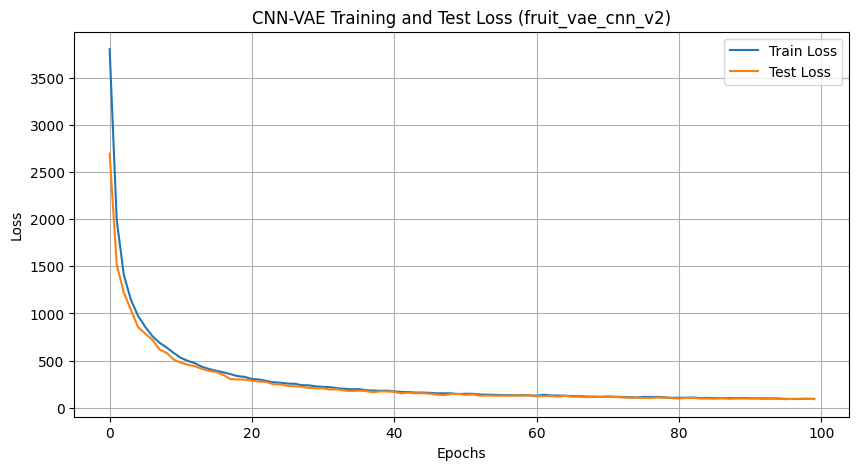

In [9]:
def train(epoch, model, optimizer, beta_kld): # Added beta_kld
    model.train()
    train_loss = 0
    if not hasattr(train_loader, 'dataset') or len(train_loader.dataset) == 0:
        print("Train loader is empty or invalid, skipping training.")
        return 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if data is None: continue
        data = data.to(DEVICE)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        # --- Pass BETA_KLD to loss function ---
        loss = loss_function(recon_batch, data, mu, log_var, beta_kld)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % (max(1, len(train_loader) // 5)) == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    avg_train_loss = train_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0
    print(f'====> Epoch: {epoch} Average train loss: {avg_train_loss:.4f}')
    return avg_train_loss

def test(epoch, model, beta_kld): # Added beta_kld
    model.eval()
    test_loss = 0
    if not hasattr(test_loader, 'dataset') or len(test_loader.dataset) == 0:
        print("Test loader is empty or invalid, skipping testing.")
        return 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if data is None: continue
            data = data.to(DEVICE)
            recon_batch, mu, log_var = model(data)
            # --- Pass BETA_KLD to loss function ---
            test_loss += loss_function(recon_batch, data, mu, log_var, beta_kld).item()
            if i == 0: # Save reconstruction from first test batch
                n = min(data.size(0), 4)
                comparison = torch.cat([data[:n], recon_batch[:n]])
                save_image(comparison.cpu(), os.path.join(RESULTS_DIR, f'reconstruction_epoch_{epoch}.png'), nrow=n)
    avg_test_loss = test_loss / len(test_loader.dataset) if len(test_loader.dataset) > 0 else 0
    print(f'====> Test set loss: {avg_test_loss:.4f}')
    return avg_test_loss

# --- Training Execution ---
SHOULD_TRAIN = True
MODEL_NAME = "fruit_vae_cnn_v2" # Potentially new model name
START_EPOCH = 1

if SHOULD_TRAIN:
    train_losses = []
    test_losses = []
    print("\nStarting Training with modified settings...")
    if not hasattr(train_loader, 'dataset') or len(train_loader.dataset) == 0:
        print("Cannot start training, train_loader is not properly initialized or empty.")
    else:
        for epoch in range(START_EPOCH, EPOCHS + 1):
            # Pass BETA_KLD to train and test
            # You could also implement beta annealing here, e.g.:
            # current_beta = min(1.0, BETA_KLD_START + (BETA_KLD_END - BETA_KLD_START) * epoch / ANNEAL_EPOCHS)
            current_beta = BETA_KLD # Using fixed beta for simplicity

            train_loss_val = train(epoch, model, optimizer, current_beta)
            test_loss_val = test(epoch, model, current_beta)
            train_losses.append(train_loss_val)
            test_losses.append(test_loss_val)

            if epoch % SAVE_MODEL == 0 or epoch == EPOCHS:
                save_model(model, optimizer, epoch, MODEL_NAME, MODELS_DIR)

            with torch.no_grad():
                sample = torch.randn(16, LATENT_DIM).to(DEVICE)
                generated_samples = model.decode(sample).cpu()
                save_image(generated_samples.view(16, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH),
                           os.path.join(RESULTS_DIR, f'{MODEL_NAME}_sample_epoch_{epoch}.png'), nrow=4)
        print("Training Finished.")
        # Plot losses (same as before, ensure paths use RESULTS_DIR)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title(f'CNN-VAE Training and Test Loss ({MODEL_NAME})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(RESULTS_DIR, f'{MODEL_NAME}_loss_curves.png'))
        plt.show()
else:
    print("Training skipped. Ensure a model is loaded for further operations.")

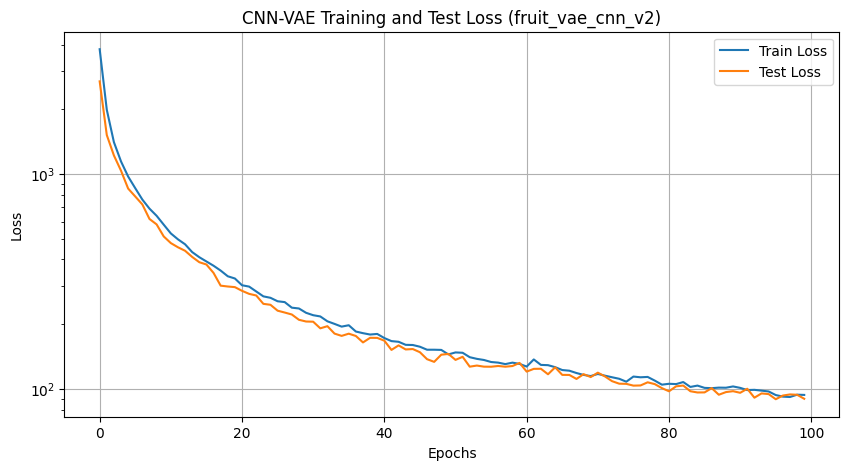

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title(f'CNN-VAE Training and Test Loss ({MODEL_NAME})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.savefig(os.path.join(RESULTS_DIR, f'{MODEL_NAME}_loss_curves.png'))
plt.show()

## 8. Loading a Trained Model (Example)

In [11]:
# Example: Load the model saved at the last epoch of training
LOAD_MODEL_EPOCH = EPOCHS # Or specify a particular epoch number if you saved multiple
LOAD_MODEL_PATH = os.path.join(MODELS_DIR, f"{MODEL_NAME}_epoch_{LOAD_MODEL_EPOCH}.pth")

if os.path.exists(LOAD_MODEL_PATH):
    loaded_model, loaded_optimizer, loaded_epoch = load_model(LOAD_MODEL_PATH, DEVICE)
    if loaded_model:
        model = loaded_model # Replace current model with the loaded one
        optimizer = loaded_optimizer # Replace optimizer
        # You could continue training from loaded_epoch + 1 if desired
        print(f"Successfully loaded model from epoch {loaded_epoch}.")
        model.eval() # Set to evaluation mode after loading for inference tasks
else:
    print(f"Model file {LOAD_MODEL_PATH} not found. Using the model from current session (if any training occurred).")
    model.eval() # Still set to eval mode

Model loaded from /content/drive/MyDrive/SeminartalkVAEsNFs/models/fruit_vae_cnn_v2_epoch_100.pth, epoch 100
Successfully loaded model from epoch 100.


## 9. Latent Space Exploration Functions

In [12]:
def explore_adaptive_latent_neighborhood(
    model,
    base_image_tensor, # The original image tensor (C, H, W) to encode
    num_samples=15,    # Number of neighborhood samples to generate (excluding original)
    radius_multiplier=1.0, # Multiplier for the learned standard deviations
    device=DEVICE,
    results_dir=RESULTS_DIR,
    model_name_prefix=MODEL_NAME
):
    """
    Encodes a base image, then generates image samples by perturbing its latent
    representation (mu) scaled by its learned standard deviations (sigma).
    Plots the original image and the generated neighborhood.

    Args:
        model: The trained VAE model.
        base_image_tensor: A single image tensor (C, H, W) on CPU.
        num_samples: Number of perturbed samples to generate.
        radius_multiplier: How many "sigmas" away to explore.
                           A value of 1.0 explores within roughly one learned std dev.
        device: Torch device.
        results_dir: Directory to save the output plot.
        model_name_prefix: Prefix for the saved plot filename.
    """
    model.eval()

    # 1. Encode the base image to get its latent mean (mu) and log_var
    base_image_batch = base_image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        base_mu, base_log_var = model.encode(base_image_batch)
        base_std = torch.exp(0.5 * base_log_var) # sigma

    base_z_center = base_mu # We will perturb around the mean

    # 2. Generate random perturbation vectors, scaled by learned std
    latent_dim = base_z_center.size(1)
    all_perturbed_z = []

    for _ in range(num_samples):
        # Generate a standard Gaussian noise vector (epsilon ~ N(0, I))
        # This represents a random direction and magnitude in a "standardized" latent space
        epsilon = torch.randn(1, latent_dim, device=device)

        # Scale epsilon by a random factor up to radius_multiplier.
        # This determines how "far" along the epsilon direction (scaled by sigma) we go.
        # To sample points *within* a scaled ellipsoid defined by sigma * radius_multiplier:
        u = torch.rand(1, 1, device=device) # random scalar between 0 and 1
        # Scale factor for epsilon, so perturbation magnitude is up to radius_multiplier * sigma
        scale_factor = u ** (1.0 / latent_dim) # For more uniform sampling within the volume
        # scale_factor = u # Simpler: uniform scaling factor, biases towards surface

        # The perturbation is epsilon scaled by the learned std and the desired multiplier/scale_factor
        # perturbation = scale_factor * radius_multiplier * base_std * epsilon # This scales epsilon components by sigma_j
                                                                           # resulting in an ellipsoid defined by base_std * radius_multiplier
        # A simpler interpretation: sample epsilon from N(0,I) and scale it directly
        # by radius_multiplier to control "how many sigmas" the perturbation can be.
        # Then, this scaled epsilon is used in the reparameterization sense.
        # z_perturbed = base_mu + (epsilon * radius_multiplier) * base_std
        # This is equivalent to z_perturbed = base_mu + epsilon_scaled_by_radius * base_std

        # Let's generate points that are *roughly* within radius_multiplier * base_std distance.
        # Sample a direction, then a magnitude within the scaled ellipsoid.
        random_direction = torch.randn(1, latent_dim, device=device)
        random_direction_unit = random_direction / torch.linalg.norm(random_direction, dim=1, keepdim=True)

        # Max perturbation in each dimension is radius_multiplier * base_std_j
        # For a point on the surface of the ellipsoid scaled by radius_multiplier:
        # z_j = mu_j + radius_multiplier * std_j * direction_unit_j
        # To sample *within* it, scale the radius_multiplier part
        current_sample_radius_factor = torch.rand(1,1, device=device) # Sample from 0 to 1

        # Perturbation: random direction, scaled by learned std and overall radius multiplier
        perturbation = random_direction_unit * (current_sample_radius_factor * radius_multiplier * base_std)

        perturbed_z = base_z_center + perturbation
        all_perturbed_z.append(perturbed_z)

    if all_perturbed_z:
        perturbed_z_batch = torch.cat(all_perturbed_z, dim=0)
        with torch.no_grad():
            neighborhood_samples_decoded = model.decode(perturbed_z_batch).cpu()
    else:
        neighborhood_samples_decoded = torch.empty(0, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)


    # 4. Prepare images for plotting (same as before)
    images_to_plot = [base_image_tensor.cpu().clamp(0,1)]
    if neighborhood_samples_decoded.numel() > 0:
        for i in range(neighborhood_samples_decoded.size(0)):
            images_to_plot.append(neighborhood_samples_decoded[i].clamp(0,1))

    images_to_plot_tensor = torch.stack(images_to_plot)

    if images_to_plot_tensor.numel() > 0 :
        plot_nrow = min(5, len(images_to_plot))
        if plot_nrow == 0 and len(images_to_plot) > 0: plot_nrow = 1

        title = f"Adaptive Latent Neighborhood (Radius Multiplier {radius_multiplier:.2f})"
        save_path = os.path.join(results_dir, f'{model_name_prefix}_latent_adaptive_neighborhood.png')

        print(f"Plotting {len(images_to_plot)} images (1 original + {num_samples} perturbed by sigma) with nrow={plot_nrow}")
        show_tensor_images(
            images_to_plot_tensor,
            num_images=len(images_to_plot),
            nrow=plot_nrow,
            title=title,
            save_path=save_path,
            show=True
        )
    else:
        print("No images to plot for adaptive neighborhood exploration.")

def interpolate_between_images(model, img1_tensor, img2_tensor, num_steps=10, device=DEVICE, output_gif_path=None, output_plot_path=None):
    """
    Encodes two images, linearly interpolates between their latent representations (mu only),
    and decodes the intermediate latent vectors.
    img1_tensor, img2_tensor: Single image tensors (C, H, W), not batches.
    """
    model.eval()

    # Add batch dimension and send to device
    img1_batch = img1_tensor.unsqueeze(0).to(device)
    img2_batch = img2_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        mu1, _ = model.encode(img1_batch)
        mu2, _ = model.encode(img2_batch)
        # For interpolation, we typically use just mu, not a reparameterized z,
        # to get a smoother path without random noise from epsilon.
        # Alternatively, one could fix epsilon or average over several epsilons.

    interpolated_images = []
    alphas = torch.linspace(0, 1, num_steps)

    gif_frames = []

    for alpha in alphas:
        inter_mu = (1 - alpha) * mu1 + alpha * mu2
        with torch.no_grad():
            decoded_img = model.decode(inter_mu).cpu().squeeze(0) # Remove batch dim
        interpolated_images.append(decoded_img)
        if output_gif_path:
            # Convert to PIL image format for imageio
            pil_img = transforms.ToPILImage()(decoded_img.clamp(0,1))
            gif_frames.append(np.array(pil_img))

    interpolated_images_tensor = torch.stack(interpolated_images)

    title = f"Latent Space Interpolation ({num_steps} steps)"
    show_tensor_images(interpolated_images_tensor, num_images=num_steps, nrow=num_steps, title=title,
                       save_path=output_plot_path or os.path.join(RESULTS_DIR, f'{MODEL_NAME}_interpolation_plot.png'))

    if output_gif_path and gif_frames:
        output_gif_path_actual = output_gif_path or os.path.join(RESULTS_DIR, f'{MODEL_NAME}_interpolation.gif')
        imageio.mimsave(output_gif_path_actual or os.path.join(RESULTS_DIR, f'{MODEL_NAME}_interpolation.gif'),gif_frames, fps=num_steps//2 if num_steps > 1 else 1)
        print(f"Interpolation GIF saved to {output_gif_path_actual}")

    return interpolated_images_tensor

## 10. Using the Exploration and Interpolation Functions

Ensure a model is loaded or trained before running this section.

Found 30 images in /content/drive/MyDrive/SeminartalkVAEsNFs/test2

Original image for ADAPTIVE neighborhood exploration:


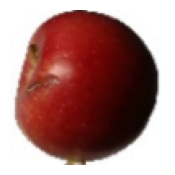

Plotting 16 images (1 original + 15 perturbed by sigma) with nrow=5


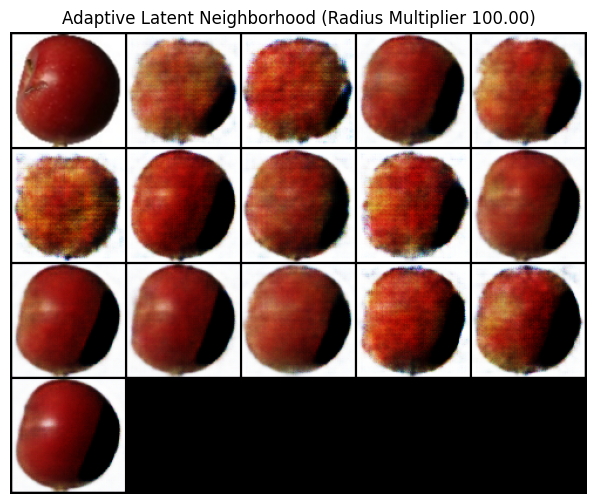

Saved image to /content/drive/MyDrive/SeminartalkVAEsNFs/results_cnn_vae_fruit/fruit_vae_cnn_v2_latent_adaptive_neighborhood.png

Interpolating between two images...
Image 1 for interpolation:


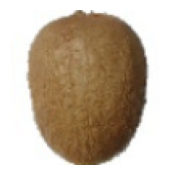

Image 2 for interpolation:


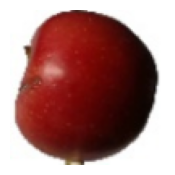

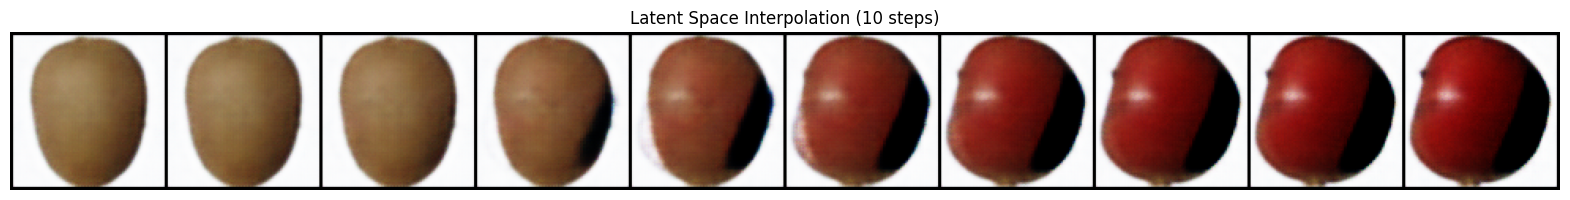

Saved image to /content/drive/MyDrive/SeminartalkVAEsNFs/results_cnn_vae_fruit/fruit_vae_cnn_v2_interpolation_strip.png
Interpolation GIF saved to /content/drive/MyDrive/SeminartalkVAEsNFs/results_cnn_vae_fruit/fruit_vae_cnn_v2_interpolation_6.gif


In [20]:
# Ensure model is in eval mode
model.eval()
BATCH_SIZE = 2
EXAMPLE_NO = 6
test_dataset_interpolate = CustomImageDataset(img_dir=YOUR_TEST_IMG_DIR, transform=transform, limit=DATASET_LIMIT // 2 if DATASET_LIMIT else None)
test_loader_interpolate = DataLoader(test_dataset_interpolate, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True if DEVICE.type == 'cuda' else False)

# 1. Explore Latent Neighborhood
if hasattr(test_loader, 'dataset') and len(test_loader.dataset) > 0:
     try:
         data_iter = iter(test_loader)
         base_image_batch_for_exp, _ = next(data_iter)

         if base_image_batch_for_exp is not None and base_image_batch_for_exp.size(0) > 0:
             single_base_image_tensor = base_image_batch_for_exp[0].cpu()

             print("\nOriginal image for ADAPTIVE neighborhood exploration:")
             show_tensor_images(single_base_image_tensor.unsqueeze(0), num_images=1, nrow=1, show=True)

             explore_adaptive_latent_neighborhood(
                 model,
                 base_image_tensor=single_base_image_tensor,
                 num_samples=15,
                 radius_multiplier=100.0 # Explore within approx. 1 standard deviation
                                       # Try 0.5 for tighter, 2.0 for wider exploration
             )
         else:
             print("Could not get a valid base image for adaptive neighborhood exploration.")
     except StopIteration:
         print("DataLoader is empty for adaptive neighborhood exploration.")
     except Exception as e:
         print(f"An error occurred during adaptive neighborhood exploration setup: {e}")

# else:
#     print("DataLoader not available for adaptive neighborhood exploration.")

# 2. Interpolate Between Two Images
print("\nInterpolating between two images...")
if hasattr(train_loader, 'dataset') and len(train_loader.dataset) >= 2:
    try:
        # Get two different images from the dataset
        data_iter = iter(test_loader_interpolate)
        img1_data, _ = next(data_iter)
        img2_data, _ = next(data_iter)

        if img1_data is not None and img2_data is not None and img1_data.size(0) > 0 and img2_data.size(0) > 0:
            img1_tensor = img1_data[0] # Take the first image from the batch (C, H, W)
            img2_tensor = img2_data[0] # Take the first image from the second batch

            print("Image 1 for interpolation:")
            show_tensor_images(img1_tensor.unsqueeze(0), num_images=1, nrow=1)
            print("Image 2 for interpolation:")
            show_tensor_images(img2_tensor.unsqueeze(0), num_images=1, nrow=1)

            _ = interpolate_between_images(model, img1_tensor, img2_tensor, num_steps=10,
                                           output_gif_path=os.path.join(RESULTS_DIR, f'{MODEL_NAME}_interpolation_{EXAMPLE_NO}.gif'),
                                           output_plot_path=os.path.join(RESULTS_DIR, f'{MODEL_NAME}_interpolation_strip.png'))
        else:
            print("Could not get two valid images for interpolation.")
    except StopIteration:
        print("Not enough data in test_loader for interpolation (need at least 2 batches or 2 images).")
    except Exception as e:
        print(f"Error during interpolation setup: {e}")
else:
    print("DataLoader not initialized or has too few images for interpolation.")

## 11. Displaying Saved GIFs (if any)

If you are in a Jupyter environment that supports displaying GIFs directly (like Google Colab), you can use `IPython.display.Image`.


Displaying interpolation GIF: /content/drive/MyDrive/SeminartalkVAEsNFs/results_cnn_vae_fruit/fruit_vae_cnn_v2_interpolation_6.gif


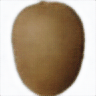

In [14]:
from IPython.display import Image as IPImage, display

interpolation_gif_path = os.path.join(RESULTS_DIR, f'{MODEL_NAME}_interpolation_{EXAMPLE_NO}.gif')
if os.path.exists(interpolation_gif_path):
    print(f"\nDisplaying interpolation GIF: {interpolation_gif_path}")
    try:
        display(IPImage(filename=interpolation_gif_path))
    except Exception as e:
        print(f"Could not display GIF: {e}. You can download it from {interpolation_gif_path}")
else:
    print(f"\nInterpolation GIF not found at {interpolation_gif_path}")


--- Loading individual fruit datasets ---
Loading apples from /content/drive/MyDrive/SeminartalkVAEsNFs/apples...
Limited dataset to 50 images from /content/drive/MyDrive/SeminartalkVAEsNFs/apples
Found 50 images in /content/drive/MyDrive/SeminartalkVAEsNFs/apples
Loading bananas from /content/drive/MyDrive/SeminartalkVAEsNFs/bananas...
Limited dataset to 50 images from /content/drive/MyDrive/SeminartalkVAEsNFs/bananas
Found 50 images in /content/drive/MyDrive/SeminartalkVAEsNFs/bananas
Loading kiwis from /content/drive/MyDrive/SeminartalkVAEsNFs/kiwis...
Limited dataset to 50 images from /content/drive/MyDrive/SeminartalkVAEsNFs/kiwis
Found 50 images in /content/drive/MyDrive/SeminartalkVAEsNFs/kiwis

Example apple images:


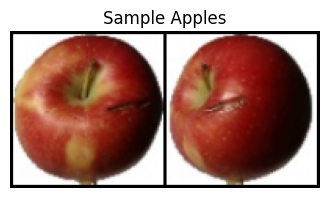

In [15]:
# Cell: Data Loading - Extended for specific fruit classes

# (CustomImageDataset class definition - same as before)
# (transform definition - same as before, using global IMG_HEIGHT, IMG_WIDTH)

# --- Define paths to your specific fruit image folders ---
# These should be inside PROJECT_BASE_PATH if you want them on Drive
APPLES_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'apples')
BANANAS_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'bananas')
KIWIS_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'kiwis')

# Create dummy fruit folders and images if they don't exist, for testing notebook flow
for fruit_dir_name in ['apples', 'bananas', 'kiwis']:
    fruit_dir_path = os.path.join(PROJECT_BASE_PATH, fruit_dir_name)
    if not os.path.exists(fruit_dir_path):
        os.makedirs(fruit_dir_path)
        print(f"Created dummy directory: {fruit_dir_path}")
        # Add a few dummy images
        if not os.listdir(fruit_dir_path): # Only if empty
            for i in range(3): # Create 3 dummy images per folder
                try:
                    dummy_pil_img = Image.fromarray(np.random.randint(0, 256, (IMG_HEIGHT+20, IMG_WIDTH+20, 3), dtype=np.uint8)) # Slightly larger to test resize
                    dummy_pil_img.save(os.path.join(fruit_dir_path, f'dummy_{fruit_dir_name}_{i}.png'))
                except Exception as e:
                    print(f"Error creating dummy fruit image in {fruit_dir_path}: {e}")


# --- Create Datasets and DataLoaders for each fruit ---
# You might want to adjust DATASET_LIMIT_PER_FRUIT based on your data and testing needs
DATASET_LIMIT_PER_FRUIT = 50 # Set to None to use all images, or a small number for quick tests

datasets_fruits = {}
dataloaders_fruits = {}
fruit_names = ["apples", "bananas", "kiwis"]
fruit_dirs = {
    "apples": APPLES_IMG_DIR,
    "bananas": BANANAS_IMG_DIR,
    "kiwis": KIWIS_IMG_DIR
}

print("\n--- Loading individual fruit datasets ---")
for fruit_name in fruit_names:
    img_dir = fruit_dirs[fruit_name]
    print(f"Loading {fruit_name} from {img_dir}...")
    current_dataset = CustomImageDataset(img_dir=img_dir, transform=transform, limit=DATASET_LIMIT_PER_FRUIT)
    datasets_fruits[fruit_name] = current_dataset
    if len(current_dataset) > 0:
        dataloaders_fruits[fruit_name] = DataLoader(
            current_dataset,
            batch_size=BATCH_SIZE, # Can use the global BATCH_SIZE or a specific one
            shuffle=False, # No need to shuffle for this encoding task
            num_workers=2,
            pin_memory=True if DEVICE.type == 'cuda' else False
        )
    else:
        print(f"WARNING: No images found for {fruit_name} in {img_dir}. Corresponding DataLoader will be empty.")
        # Create a dummy loader to prevent errors if a fruit class has no images
        dataloaders_fruits[fruit_name] = DataLoader(
            DummyDataset((IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH), 0), batch_size=BATCH_SIZE
        )

# Example: Show some apple images if loaded
if "apples" in dataloaders_fruits and len(dataloaders_fruits["apples"].dataset) > 0:
    try:
        example_apples, _ = next(iter(dataloaders_fruits["apples"]))
        if example_apples.numel() > 0:
            print("\nExample apple images:")
            show_tensor_images(example_apples, num_images=min(BATCH_SIZE, 4), nrow=2, title="Sample Apples")
    except StopIteration:
        print("Apple DataLoader is empty.")
    except Exception as e:
        print(f"Error showing example apples: {e}")

In [16]:
# Cell: Function to Get Average Latent Representations for a Class

def get_average_latent_representation(model, dataloader, device=DEVICE):
    """
    Encodes all images from a dataloader and computes the average mu and log_var.
    Returns average_mu, average_log_var (or average_std).
    """
    model.eval()
    all_mus = []
    all_log_vars = []

    if not hasattr(dataloader, 'dataset') or len(dataloader.dataset) == 0:
        print("Warning: DataLoader is empty or invalid. Cannot compute average latent representation.")
        return None, None

    with torch.no_grad():
        for images, _ in dataloader:
            if images is None or images.numel() == 0: continue
            images = images.to(device)
            mu, log_var = model.encode(images)
            all_mus.append(mu.cpu())
            all_log_vars.append(log_var.cpu())

    if not all_mus: # No valid images were processed
        print("Warning: No images processed from DataLoader. Cannot compute average latent representation.")
        return None, None

    all_mus_tensor = torch.cat(all_mus, dim=0)
    all_log_vars_tensor = torch.cat(all_log_vars, dim=0)

    avg_mu = torch.mean(all_mus_tensor, dim=0, keepdim=True) # Keep batch dim for consistency
    # For log_var, averaging log_vars directly is common.
    # Alternatively, average variances: avg_var = torch.mean(torch.exp(all_log_vars_tensor), dim=0)
    # then avg_log_var = torch.log(avg_var)
    avg_log_var = torch.mean(all_log_vars_tensor, dim=0, keepdim=True)
    avg_std = torch.exp(0.5 * avg_log_var)

    print(f"Computed average latent representation: mu_shape={avg_mu.shape}, log_var_shape={avg_log_var.shape}")
    return avg_mu, avg_log_var # Or return avg_mu, avg_std

In [17]:
# Cell: Functions for Class-Specific Generation and Interpolation

def generate_from_avg_latent(model, avg_mu, avg_log_var, num_samples=8, use_sampling=True, device=DEVICE):
    """
    Generates images by sampling from N(avg_mu, exp(avg_log_var)) or by decoding avg_mu directly.
    """
    model.eval()
    avg_mu = avg_mu.to(device)
    avg_log_var = avg_log_var.to(device)

    generated_images_list = []
    with torch.no_grad():
        for _ in range(num_samples):
            if use_sampling:
                # Sample z from the average distribution
                z_sample = model.reparameterize(avg_mu.repeat(1,1), avg_log_var.repeat(1,1)) # Repeat if avg_mu/log_var is (1, latent_dim)
            else:
                # Decode the average mu directly
                z_sample = avg_mu.repeat(1,1)

            decoded_img = model.decode(z_sample).cpu() # Should already be (1, C, H, W)
            generated_images_list.append(decoded_img.squeeze(0)) # Remove batch dim

    if not generated_images_list:
        return torch.empty(0, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)

    return torch.stack(generated_images_list)


def interpolate_between_average_latents(
    model,
    mu1, log_var1, # For fruit 1
    mu2, log_var2, # For fruit 2
    num_steps=10,
    device=DEVICE,
    output_gif_path=None,
    output_plot_path=None,
    model_name_prefix=MODEL_NAME # Use global or pass
):
    """
    Interpolates between the average mu of two fruit classes.
    """
    model.eval()
    mu1, mu2 = mu1.to(device), mu2.to(device)
    # log_var1, log_var2 are not directly used for mu interpolation, but could be for z interpolation

    interpolated_images = []
    alphas = torch.linspace(0, 1, num_steps, device=device) # Generate alphas on device
    gif_frames = []

    for alpha in alphas:
        # Interpolate only the mean for smoother visual transition
        inter_mu = (1 - alpha) * mu1 + alpha * mu2
        # Optional: could also interpolate log_var and sample z
        # inter_log_var = (1 - alpha) * log_var1 + alpha * log_var2
        # inter_z = model.reparameterize(inter_mu, inter_log_var)

        with torch.no_grad():
            decoded_img = model.decode(inter_mu).cpu().squeeze(0) # Remove batch dim
        interpolated_images.append(decoded_img)
        if output_gif_path:
            pil_img = transforms.ToPILImage()(decoded_img.clamp(0,1))
            gif_frames.append(np.array(pil_img))

    if not interpolated_images:
        print("No images generated for interpolation.")
        return None

    interpolated_images_tensor = torch.stack(interpolated_images)

    title = f"Interpolation between Average Latents ({num_steps} steps)"
    actual_plot_path = output_plot_path or os.path.join(RESULTS_DIR, f'{model_name_prefix}_avg_latent_interpolation_plot.png')
    show_tensor_images(interpolated_images_tensor, num_images=num_steps, nrow=num_steps, title=title,
                       save_path=actual_plot_path)

    if output_gif_path and gif_frames:
        actual_gif_path = output_gif_path or os.path.join(RESULTS_DIR, f'{model_name_prefix}_avg_latent_interpolation.gif')
        imageio.mimsave(actual_gif_path, gif_frames, fps=num_steps//2 if num_steps > 1 else 1)
        print(f"Interpolation GIF saved to {actual_gif_path}")

    return interpolated_images_tensor

In [ ]:
# --- Ensure model is loaded and in eval mode ---
# (Assume model is already loaded or trained from previous cells)
model.eval()
print("\n--- Exploring Latent Space for Fruit Classes ---")

average_latents = {}
for fruit_name in fruit_names:
    print(f"\nProcessing {fruit_name}...")
    if fruit_name in dataloaders_fruits and len(dataloaders_fruits[fruit_name].dataset) > 0:
        avg_mu, avg_log_var = get_average_latent_representation(model, dataloaders_fruits[fruit_name], DEVICE)
        if avg_mu is not None:
            average_latents[fruit_name] = {'mu': avg_mu, 'log_var': avg_log_var}

            # Generate images from this average latent representation
            print(f"Generating images for average {fruit_name} (from N(mu,sigma)):")
            generated_class_samples_N_mu_sigma = generate_from_avg_latent(model, avg_mu, avg_log_var, num_samples=8, use_sampling=True)
            if generated_class_samples_N_mu_sigma.numel() > 0:
                 show_tensor_images(generated_class_samples_N_mu_sigma, num_images=8, nrow=4,
                                   title=f"Generated {fruit_name.capitalize()} (from N(avg_mu, avg_sigma))",
                                   save_path=os.path.join(RESULTS_DIR, f'{MODEL_NAME}_generated_avg_{fruit_name}_N_mu_sigma.png'))

            print(f"Generating image for average {fruit_name} (from mu directly):")
            generated_class_samples_mu_direct = generate_from_avg_latent(model, avg_mu, avg_log_var, num_samples=1, use_sampling=False)
            if generated_class_samples_mu_direct.numel() > 0:
                show_tensor_images(generated_class_samples_mu_direct, num_images=1, nrow=1,
                                   title=f"Generated {fruit_name.capitalize()} (from avg_mu directly)",
                                   save_path=os.path.join(RESULTS_DIR, f'{MODEL_NAME}_generated_avg_{fruit_name}_mu_direct.png'))
        else:
            print(f"Could not compute average latent representation for {fruit_name}.")
    else:
        print(f"Skipping {fruit_name} as its DataLoader is empty.")


# --- Interpolations between average fruit latents ---
if "apples" in average_latents and "bananas" in average_latents:
    print("\nInterpolating between average Apples and Bananas...")
    interpolate_between_average_latents(
        model,
        average_latents["apples"]['mu'], average_latents["apples"]['log_var'],
        average_latents["bananas"]['mu'], average_latents["bananas"]['log_var'],
        num_steps=10, model_name_prefix=f"{MODEL_NAME}_apples_bananas"
    )

if "apples" in average_latents and "kiwis" in average_latents:
    print("\nInterpolating between average Apples and Kiwis...")
    interpolate_between_average_latents(
        model,
        average_latents["apples"]['mu'], average_latents["apples"]['log_var'],
        average_latents["kiwis"]['mu'], average_latents["kiwis"]['log_var'],
        num_steps=10, model_name_prefix=f"{MODEL_NAME}_apples_kiwis"
    )

if "bananas" in average_latents and "kiwis" in average_latents:
    print("\nInterpolating between average Bananas and Kiwis...")
    interpolate_between_average_latents(
        model,
        average_latents["bananas"]['mu'], average_latents["bananas"]['log_var'],
        average_latents["kiwis"]['mu'], average_latents["kiwis"]['log_var'],
        num_steps=10, model_name_prefix=f"{MODEL_NAME}_bananas_kiwis"
    )

print("\n--- Fruit Class Latent Space Exploration Finished ---")

# (Optional: Display GIFs if created - same code as before using IPython.display.Image)

Output hidden; open in https://colab.research.google.com to view.